# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Universidad Nacional de Córdoba
---

### Importación de librerías

In [1]:
import warnings
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared

from pandas.plotting import lag_plot

import pyarrow
import fastparquet

import statsmodels

### Lectura del dataset 

In [2]:
df = pd.read_parquet('../notebooks_tp2/sin_codificar.parquet')
df

,dni_titular_movimiento,fecha_cupon_movimiento,moneda_movimiento,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,anio_mes_cupon,sexo_descripcion,monto_ajustado,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
0,0001686b52949b5461ffcbc766687e45031,2020-08-25,0,PL,0,202008,Hombre,5.52,Sector_Empleado_Comercio,61.0,92,0,Otros,REGION PAMPEANA
1,000220fa96ec5af89817894033f8099c547,2020-08-25,0,PL,0,202008,Mujer,15.68,Sector_Sin_Datos,29.0,2,0,Sin_datos,REGION CUYO
2,0002be202de47dfae9cc2304d91161be595,2020-08-25,0,PL,0,202008,Mujer,5.46,Sector_Sin_Datos,28.0,95,0,Soltero,REGION PAMPEANA
3,000e137d0af42e193be1ff670c00d4d1506,2020-08-25,0,PL,0,202008,Hombre,2.50,Sector_Empleado_Comercio,40.0,151,0,Soltero,REGION PAMPEANA
4,0009d010e4faf69552a814a33832b185877,2020-08-25,0,PL,0,202008,Mujer,2.10,Sector_Empleado_Comercio,36.0,87,0,Soltero,REGION PAMPEANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124309,0001f61dd2845a7e653ebfdaf22dab3b373,2021-05-14,0,PC,3,202105,Mujer,20329.24,Sector_Empleado_Comercio,48.0,98,0,Casado,REGION PATAGONIA
124310,0001f61dd2845a7e653ebfdaf22dab3b373,2021-05-14,0,PC,3,202105,Mujer,20329.24,Sector_Empleado_Comercio,48.0,98,0,Casado,REGION PATAGONIA
124311,0006c15ca823454b68c189da1344d9d7317,2021-05-14,0,PC,3,202105,Hombre,13210.67,Sector_No_Operativo,66.0,105,0,Casado,REGION NORDESTE
124312,0000ab27a0ed815f947df8bcb834ff97975,2021-05-03,0,PC,3,202105,Hombre,121.73,Sector_Empleado_Comercio,74.0,140,0,Soltero,REGION NOROESTE


Ordenamos nuestro conjunto de datos en función a la variable anio_mes_cupon.

In [3]:
df = df[~df.duplicated()]
df.duplicated().value_counts()

False    54010
dtype: int64

In [4]:
df = df.sort_values(by = ['anio_mes_cupon'], ascending = True)
df

,dni_titular_movimiento,fecha_cupon_movimiento,moneda_movimiento,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,anio_mes_cupon,sexo_descripcion,monto_ajustado,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
85858,0001a3ea0e2a1394ddba4679b09ca7a1561,2020-07-31,0,PL,3,202007,Hombre,181.16,Sector_Sin_Datos,80.0,19,5,Soltero,REGION NOROESTE
74714,00037938025ac60849e60d3f3fa42cdc833,2020-07-28,3,PL,3,202007,Mujer,618.52,Sector_Educativo,39.0,124,1,Soltero,REGION PAMPEANA
74715,00037938025ac60849e60d3f3fa42cdc833,2020-07-26,3,PL,3,202007,Mujer,1350.43,Sector_Educativo,39.0,124,1,Soltero,REGION PAMPEANA
101268,0003a7e1566088a9a9b1fc374c49ef4e389,2020-07-29,0,VI,22,202007,Hombre,1319.95,Sector_Sin_Datos,50.0,45,9,Casado,REGION PAMPEANA
101269,0003a7e1566088a9a9b1fc374c49ef4e389,2020-07-25,0,VI,22,202007,Hombre,4619.57,Sector_Sin_Datos,50.0,45,9,Casado,REGION PAMPEANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72398,00068ec69c7a0fef0047dece18e1d905386,2021-05-07,0,ZE,3,202105,Mujer,1968.66,Sector_Sin_Datos,58.0,78,0,Casado,REGION PAMPEANA
72399,0000e7b72ab4fe0dbdcba6e189bc4bd3190,2021-05-11,0,ZE,3,202105,Mujer,2462.32,Sector_Empleado_Comercio,57.0,121,0,Casado,REGION NOROESTE
72389,0003dd9ab940e4a4fb953141abbe57aa237,2021-05-10,0,ZE,3,202105,Hombre,2814.60,Sector_Sin_Datos,41.0,3,0,Soltero,REGION NORDESTE
124313,0000ab27a0ed815f947df8bcb834ff97975,2021-05-03,0,PC,3,202105,Hombre,12284.16,Sector_Empleado_Comercio,74.0,140,0,Soltero,REGION NOROESTE


In [5]:
df['monto_ajustado'].describe().round(2)

count    54010.00
mean      1626.05
std       4172.44
min     -35117.69
25%         88.42
50%        271.75
75%       1337.98
max      63616.14
Name: monto_ajustado, dtype: float64

Distribución de nuestro target respecto a nuestros features

### ScatterPlot de Features y Target

In [6]:
df_sin_docu = df.copy()
df_sin_docu.drop(columns=['dni_titular_movimiento','monto_ajustado'], inplace=True)
df_sin_docu['monto_ajustado'] = df['monto_ajustado']

In [7]:
col_x = df_sin_docu.iloc[:,:-1].columns.values
col_x

array(['fecha_cupon_movimiento', 'moneda_movimiento',
       'producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento',
       'anio_mes_cupon', 'sexo_descripcion', 'cargo_sector_desc_hist',
       'edad_cliente', 'antig_cliente', 'comercio_cat',
       'estado_civil_cat', 'region'], dtype=object)

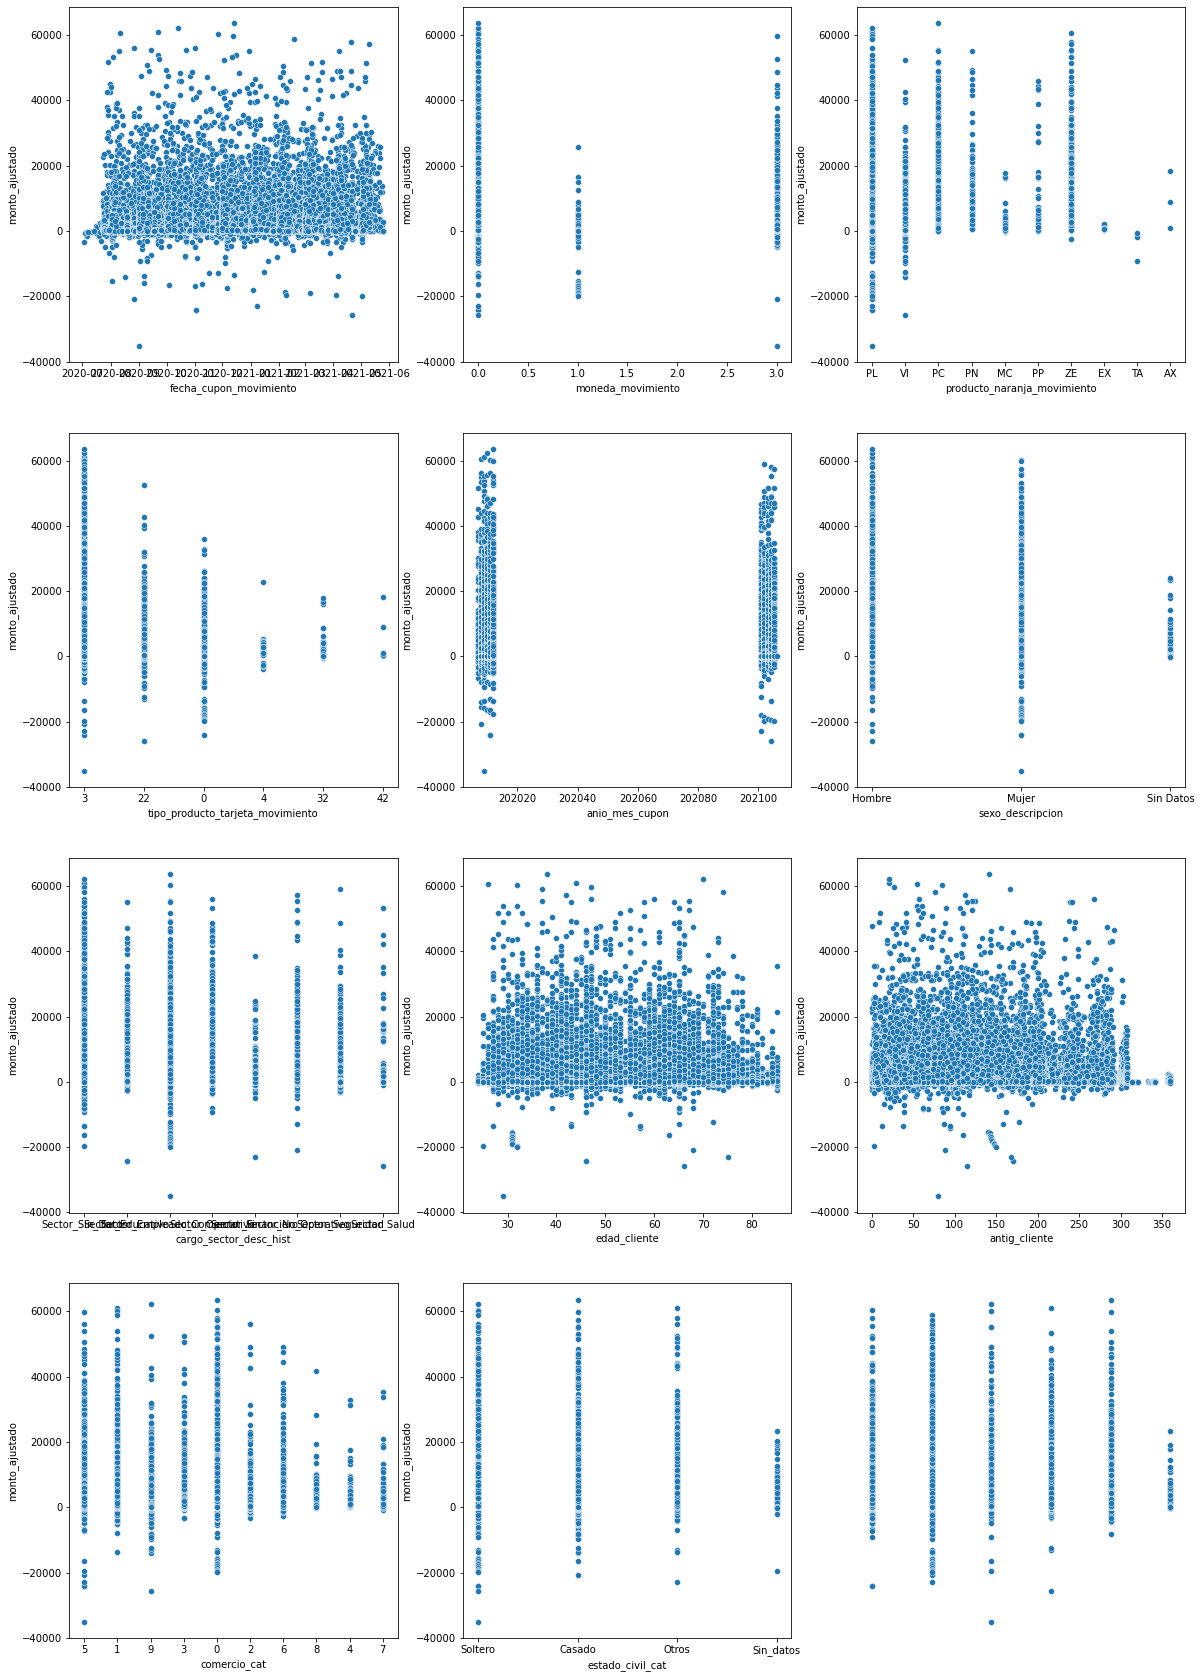

In [8]:
n_cols = 3
n_rows = math.ceil(len(col_x)/3)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
count = 0
for i in col_x:    
    # Calculamos filas y columnas
    row = math.floor(count / n_cols)
    col = count % n_cols
    # Configuramos visualización
    ax = axs[row, col]
    # Visualizamos la distribución de variable
    sns.scatterplot(data=df_sin_docu, x=i, y='monto_ajustado', ax=ax)
    count =count +1

axs[n_rows-1,n_cols-1].axis('off')
plt.show()

In [9]:
# df.loc[:,'fecha_cupon_movimiento'] = pd.to_datetime(df['fecha_cupon_movimiento']).astype(int)/10**11  >> Me daba error "Juani"
df['fecha_cupon_movimiento'] = df['fecha_cupon_movimiento'].values.astype(float)/10**11

In [10]:
df['moneda_movimiento'] = df['moneda_movimiento'].astype(str)

In [11]:
df.dtypes

dni_titular_movimiento               object
fecha_cupon_movimiento              float64
moneda_movimiento                    object
producto_naranja_movimiento          object
tipo_producto_tarjeta_movimiento     object
anio_mes_cupon                        int64
sexo_descripcion                     object
monto_ajustado                      float64
cargo_sector_desc_hist               object
edad_cliente                        float64
antig_cliente                         int64
comercio_cat                         object
estado_civil_cat                     object
region                               object
dtype: object

### Seleccion de columnas

In [12]:
ordinal_ft = 'dni_titular_movimiento'
target = 'monto_ajustado'
target_c = 'fg_aumentado'

# Features numericas
num_features = ['anio_mes_cupon', 'edad_cliente', 'antig_cliente', 'fecha_cupon_movimiento']

# Features categoricas de la transaccion
trans_ft = ['producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento', 'moneda_movimiento', 'comercio_cat']

# Features categoricas del cliente
client_ft = ['sexo_descripcion', 'cargo_sector_desc_hist', 'estado_civil_cat', 'region']

In [13]:
df = df.sort_values(by = ['fecha_cupon_movimiento'], ascending = True)

cat_transformer = OneHotEncoder(handle_unknown='ignore')

encoder = ColumnTransformer(
    transformers=[
        ('dni', 'drop', [ordinal_ft]),
        ('num', 'passthrough', num_features),
        ('trans', cat_transformer, trans_ft),
        ('client', cat_transformer, client_ft),
        ('target', 'passthrough', [target])])
df_enc = encoder.fit_transform(df)
cols = encoder.get_feature_names()

df_enc.shape

(54010, 55)

In [14]:
dff_enc = pd.DataFrame.sparse.from_spmatrix(df_enc, columns=[cols]).sparse.to_dense()

In [15]:
# Agregar feature ordinal al principio del dataframe
cols_o = np.hstack([[ordinal_ft],cols])
df_stack = np.hstack([df[[ordinal_ft]],dff_enc])
df_encode = pd.DataFrame(df_stack , columns=cols_o)

# Funciones de agregacion para cada columna
aggr = {} 
aggr.update(dict.fromkeys([x for x in cols if 'client' in x], 'max'))
aggr.update(dict.fromkeys([x for x in cols if 'trans' in x], 'sum'))
aggr.update({target:'sum'})

In [16]:
df_encode[num_features + [x for x in cols if 'trans' in x]] = \
df_encode[num_features + [x for x in cols if 'trans' in x]].apply(pd.to_numeric)
df_encode.dtypes

dni_titular_movimiento                  object
anio_mes_cupon                         float64
edad_cliente                           float64
antig_cliente                          float64
fecha_cupon_movimiento                 float64
trans__x0_AX                           float64
trans__x0_EX                           float64
trans__x0_MC                           float64
trans__x0_PC                           float64
trans__x0_PL                           float64
trans__x0_PN                           float64
trans__x0_PP                           float64
trans__x0_TA                           float64
trans__x0_VI                           float64
trans__x0_ZE                           float64
trans__x1_0                            float64
trans__x1_22                           float64
trans__x1_3                            float64
trans__x1_32                           float64
trans__x1_4                            float64
trans__x1_42                           float64
trans__x2_0  

### Agrupación x Mes

In [17]:
# Agrupamiento por mes
group = ['dni_titular_movimiento', 'anio_mes_cupon']

df_mes = df_encode.groupby(group).agg(aggr).reset_index() # edad y antiguedad

### Agrupación x Fecha

In [18]:
# Agrupamiento por fecha
group = ['dni_titular_movimiento', 'fecha_cupon_movimiento']

df_fecha = df_encode.groupby(group).agg(aggr).reset_index() # edad y antiguedad

In [19]:
df_encode.describe()

,anio_mes_cupon,edad_cliente,antig_cliente,fecha_cupon_movimiento,trans__x0_AX,trans__x0_EX,trans__x0_MC,trans__x0_PC,trans__x0_PL,trans__x0_PN,...,trans__x3_0,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9
count,54010.000000,54010.000000,54010.000000,5.401000e+04,54010.000000,54010.000000,54010.000000,54010.000000,54010.000000,54010.000000,...,54010.000000,54010.000000,54010.000000,54010.000000,54010.000000,54010.000000,54010.000000,54010.000000,54010.000000,54010.000000
mean,202050.978171,49.553564,112.846732,1.608253e+07,0.000056,0.000796,0.003129,0.020515,0.785206,0.001944,...,0.448250,0.207462,0.036512,0.021329,0.001555,0.104721,0.015238,0.003092,0.006517,0.155323
std,45.986864,14.765734,78.734504,6.861604e+04,0.007453,0.028205,0.055851,0.141754,0.410683,0.044049,...,0.497319,0.405493,0.187561,0.144481,0.039407,0.306197,0.122499,0.055520,0.080467,0.362216
min,202007.000000,24.000000,0.000000,1.593734e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,202010.000000,37.000000,47.000000,1.602547e+07,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,202012.000000,47.000000,97.000000,1.608595e+07,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,202102.000000,62.000000,169.000000,1.614211e+07,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,202106.000000,85.000000,360.000000,1.621901e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df_mes.describe()

,anio_mes_cupon,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,client__x1_Sector_No_Operativo,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
count,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,...,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000
mean,202052.953245,49.149536,107.739755,0.460836,0.533118,0.006046,0.058444,0.193202,0.011017,0.084106,...,1.505441,0.264947,0.154776,0.011286,0.759909,0.110574,0.022437,0.047293,1.127099,11799.386270
std,46.437423,14.954749,76.457279,0.498497,0.498935,0.077526,0.234597,0.394836,0.104389,0.277565,...,2.712571,0.909321,0.913168,0.166800,1.622287,0.710803,0.303002,0.442828,2.920973,14911.904828
min,202007.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14160.390000
25%,202010.000000,36.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,958.790000
50%,202012.000000,47.000000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6339.410000
75%,202103.000000,61.000000,156.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,17236.215000
max,202106.000000,85.000000,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,18.000000,17.000000,7.000000,50.000000,27.000000,14.000000,12.000000,60.000000,134045.420000


In [21]:
df_fecha.describe()

,fecha_cupon_movimiento,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,client__x1_Sector_No_Operativo,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
count,3.198100e+04,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,...,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000,31981.000000
mean,1.608104e+07,49.380664,112.753604,0.466527,0.527688,0.005785,0.073606,0.207592,0.016791,0.079766,...,0.350364,0.061662,0.036021,0.002627,0.176855,0.025734,0.005222,0.011007,0.262312,2746.093994
std,6.941602e+04,14.749501,78.827104,0.498886,0.499241,0.075838,0.261133,0.405589,0.128490,0.270935,...,0.743182,0.294222,0.238330,0.056414,0.449992,0.191422,0.084829,0.122273,0.568686,5462.347989
min,1.593734e+07,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-19822.770000
25%,1.602115e+07,37.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,274.960000
50%,1.608509e+07,47.000000,98.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,811.150000
75%,1.614211e+07,61.000000,170.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2703.440000
max,1.621901e+07,85.000000,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,8.000000,6.000000,2.000000,6.000000,7.000000,5.000000,5.000000,7.000000,68650.150000


# Modelos de Regresión - Prediccion de monto, prediccion de gasto de un dia, prediccion de gasto de un mes

## Linear SVR - Default

In [22]:
# Preproceso 1 para SGDRegressor - Default, RMSE 3395.724
df = df_encode.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = LinearSVR(random_state=0)

In [23]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [24]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=True)

#### Preproceso y ajuste

In [25]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [26]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
svr = model

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [28]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 17404625.214, Valid error 15141200.201


In [29]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 4171.885, Valid error RMSE 3891.17


In [30]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 1382.045, Valid error MAE 1313.869


Visualizamos nuestra variable target (real y predicción)

In [31]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,16203.00
mean,1570.28
std,3983.21
min,-19822.00
25%,86.00
50%,267.00
75%,1309.00
max,62261.00


In [32]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,16203.00
mean,589.61
std,582.57
min,-262.51
25%,102.71
50%,347.88
75%,776.71
max,2317.41


## Linear SVR - Grid Search

In [33]:
param_grid = {
    'regressor__epsilon': [0.1, 0.01, 0.0001,0.001],
    'regressor__tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'regressor__C': [1, 2, 0.01, 0.001],
    'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

In [34]:
# Preproceso 1 para SGDRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = LinearSVR(random_state=0)

In [35]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [36]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [37]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [146]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, n_iter=40)

model.fit(X_train, y_train)
svr_cv = model

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 36 is smaller than n_iter=40. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


KeyboardInterrupt: 

In [41]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [42]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 116561350.044, Valid error 135760481.582


In [43]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 10796.358, Valid error RMSE 11651.63


In [44]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 7171.465, Valid error MAE 7466.199


Visualizamos nuestra variable target (real y predicción)

In [45]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [46]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,11414.73
std,8218.79
min,-708.86
25%,5262.31
50%,9382.17
75%,15741.21
max,64915.29


## SGDRegressor - Default

In [47]:
# Preproceso 1 para SGDRegressor - Default, RMSE 3395.724
df = df_encode.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = SGDRegressor(random_state=0, shuffle=False)

In [48]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [49]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=True)

#### Preproceso y ajuste

In [50]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [51]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
sgd = model

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [52]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [53]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 13856707.465, Valid error 11858351.468


In [54]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 3722.46, Valid error RMSE 3443.596


In [55]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 1543.517, Valid error MAE 1487.678


Visualizamos nuestra variable target (real y predicción)

In [56]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,10802.00
mean,1549.12
std,3902.70
min,-19121.00
25%,85.00
50%,266.00
75%,1299.00
max,62261.00


In [57]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,10802.00
mean,1623.38
std,2009.97
min,-1495.67
25%,291.92
50%,1527.08
75%,1946.24
max,9713.87


## SGDRegressor- Grid Search

In [58]:
param_grid = {
    'regressor__loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'regressor__penalty': ['l2','l1'],
    'regressor__alpha': [0.01, 0.1, 1],
    'regressor__epsilon': [0.1, 0.01],
    'regressor__tol': [1e-3, 1e-4],
    'regressor__learning_rate': ['optimal', 'adaptive', 'invscaling', 'constant']
    #'max_iter': [1000, 2000, 5000]
}

In [59]:
# Preproceso 1 para SGDRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = SGDRegressor(random_state=0, shuffle=False)

In [60]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [61]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [63]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [149]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, n_iter=20)

model.fit(X_train, y_train)
sgd_cv = model

KeyboardInterrupt: 

In [65]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [66]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 116561350.044, Valid error 135760481.582


In [67]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 10796.358, Valid error RMSE 11651.63


In [68]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 7171.465, Valid error MAE 7466.199


Visualizamos nuestra variable target (real y predicción)

In [69]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [70]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,11414.73
std,8218.79
min,-708.86
25%,5262.31
50%,9382.17
75%,15741.21
max,64915.29


## KNeighborsRegressor - Default

In [71]:
# Preproceso 1 para SGDRegressor - GridSearch, RMSE 3778.109
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = KNeighborsRegressor()

In [72]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [73]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

In [74]:
X_train.shape

(5210, 53)

In [75]:
X_val.shape

(2233, 53)

#### Preproceso y ajuste

In [76]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [77]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
knn = model

In [78]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [79]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 73063078.761, Valid error 174264083.239


In [80]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 8547.694, Valid error RMSE 13200.912


In [81]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 5119.237, Valid error MAE 7767.42


Visualizamos nuestra variable target (real y predicción)

In [82]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [83]:
pd.DataFrame(y_valid_pred.astype(int), columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,9940.77
std,9474.78
min,-608.00
25%,1690.00
50%,7862.00
75%,15513.00
max,63892.00


## KNeighborsRegressor - Grid Search

In [84]:
# Preproceso 1 para KNeighborsRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = KNeighborsRegressor()

In [85]:
param_grid = {
    'regressor__n_neighbors': [20,25,30,35],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto','ball_tree','kd_tree','brute'],
    'regressor__p': [1,2]
}

In [86]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [87]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [88]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [89]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5)

model.fit(X_train, y_train)
knn_cv = model

In [90]:
model.best_params_

{'regressor__algorithm': 'auto',
 'regressor__n_neighbors': 35,
 'regressor__p': 1,
 'regressor__weights': 'distance'}

In [91]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [92]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 0.0, Valid error 239648381.735


In [93]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 0.0, Valid error RMSE 15480.581


In [94]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 0.0, Valid error MAE 10827.114


Visualizamos nuestra variable target (real y predicción)

In [95]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [96]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,10778.77
std,5088.35
min,909.07
25%,7251.52
50%,9938.28
75%,13413.42
max,35151.78


## GaussianProcessRegressor - Default

In [97]:
# Preproceso 1 para GaussianProcessRegressor - Default
df = df_fecha.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = GaussianProcessRegressor(random_state=0) # Kernel?

In [98]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [99]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [100]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [101]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
gpr = model

In [102]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [103]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 17521922.82, Valid error 5542803470.328


In [104]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 4185.92, Valid error RMSE 74450.007


In [105]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 1918.714, Valid error MAE 4757.832


Visualizamos nuestra variable target (real y predicción)

In [106]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,9595.00
mean,2684.01
std,5507.10
min,-19822.00
25%,270.50
50%,767.00
75%,2638.50
max,68650.00


In [107]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,9595.00
mean,2974.70
std,74394.77
min,-538110.50
25%,528.75
50%,1956.75
75%,2865.25
max,7081585.12


## GaussianProcessRegressor - Grid Search 

In [108]:
ker_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

kernel_list = [ker_rbf, ker_rq, ker_expsine]

param_grid = {"regressor__kernel": kernel_list,
              "regressor__alpha": [0.1]}

In [109]:
# Preproceso 1 para GaussianProcessRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = GaussianProcessRegressor(random_state=0) # Kernel?

In [110]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [111]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [112]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [113]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5)

model.fit(X_train, y_train)
gpr_cv = model

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit

In [114]:
model.best_params_

{'regressor__alpha': 0.1, 'regressor__kernel': 1**2 * RBF(length_scale=1)}

In [115]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [116]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 6405428.804, Valid error 344970116.441


In [117]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 2530.895, Valid error RMSE 18573.371


In [118]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 1434.877, Valid error MAE 11219.143


Visualizamos nuestra variable target (real y predicción)

In [119]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [120]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,1405.33
std,2391.18
min,-6546.23
25%,64.01
50%,486.91
75%,1852.86
max,23528.79


## XGBRegressor - Default

In [121]:
# Preproceso 1 para XGBRegressor - Default
df = df_encode.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = XGBRegressor(random_state=0)

In [122]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [123]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

#### Preproceso y ajuste

In [124]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [125]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
xgb = model

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [126]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [127]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 13490715.627, Valid error 11485237.849


In [128]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 3672.971, Valid error RMSE 3388.988


In [129]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 1498.49, Valid error MAE 1444.144


Visualizamos nuestra variable target (real y predicción)

In [130]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,10802.00
mean,1549.12
std,3902.70
min,-19121.00
25%,85.00
50%,266.00
75%,1299.00
max,62261.00


In [131]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,10802.00
mean,1627.94
std,2100.64
min,-11190.87
25%,165.56
50%,1501.43
75%,1686.48
max,17000.77


## XGBRegressor - Grid Search

In [132]:
# Preproceso 1 para KNeighborsRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = XGBRegressor(random_state=0)

In [133]:
param_grid = {'regressor__n_estimators': [8,10,15,20],
              'regressor__reg_alpha': [5, 10, 15],
#              'regressor__max_depth': [20, 25, 30, 35],
              'regressor__booster' : ['gbtree', 'gblinear','dart']}
    

In [134]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [135]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [136]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [137]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5)

model.fit(X_train, y_train)
xgb_cv = model

In [138]:
model.best_params_

{'regressor__booster': 'gblinear',
 'regressor__n_estimators': 8,
 'regressor__reg_alpha': 10}

In [139]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [140]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 103796573.0, Valid error 128020215.044


In [141]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 10188.06, Valid error RMSE 11314.602


In [142]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 6593.421, Valid error MAE 7054.627


Visualizamos nuestra variable target (real y predicción)

In [143]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [144]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,11754.24
std,10299.19
min,-1435.51
25%,4091.25
50%,8803.28
75%,16333.88
max,83629.88


## VotingRegressor - Default

In [145]:
from sklearn.ensemble import VotingRegressor

In [231]:
# Preproceso 1 para GaussianProcessRegressor - GridSearch
df = df_encode.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = VotingRegressor([('svr', svr),
                          ('sgd', sgd),
                          ('knn', knn),
                          ('gpr', gpr),
                          ('xgb', xgb)])

In [232]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [233]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [234]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [235]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [315]:
model.best_params_

{'regressor__alpha': 0.1, 'regressor__kernel': 1**2 * RBF(length_scale=1)}

#### Evaluacion de predicciones

In [316]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

In [317]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 6405428.804, Valid error 344970116.441


In [318]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 2530.895, Valid error RMSE 18573.371


In [319]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 1434.877, Valid error MAE 11219.143


Visualizamos nuestra variable target (real y predicción)

In [320]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [321]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,1405.33
std,2391.18
min,-6546.23
25%,64.01
50%,486.91
75%,1852.86
max,23528.79


# Modelos de Clasificacion - Predecir aumento de gasto mensual

## Preprocesamiento

### 1.2 Creación de variable categórica 

Creamos una columna que indica si un cliente ha aumentado su consumo personal mes a mes. El mes inicial para cada cliente se inicializa en 0.

Cabe destacar que a la hora de agrupar los movimientos en cada mes, se considera la fecha de cierre de la tarjeta, por lo cual cada mes comprende desde el dia 25 del mes anterior hasta el dia 24 del corriente, inclusive. 

In [236]:
# Agregación de la nueva columna seteada en 0.
# En la iteración, se le cambia el valor a 1 en caso de que cumpla con las condiciones preestablecidas.

df_mes['fg_aumentado'] = 0
for i in range(1,len(df_mes)):
    if (df_mes.iloc[i]['dni_titular_movimiento'] == df_mes.iloc[i-1]['dni_titular_movimiento']) \
        & (df_mes.iloc[i]['anio_mes_cupon'] > df_mes.iloc[i-1]['anio_mes_cupon']):
            var_mes = df_mes.iloc[i]['monto_ajustado'] - df_mes.iloc[i-1]['monto_ajustado']
            if (var_mes > (abs(df_mes.iloc[i-1]['monto_ajustado'])*0.1)):
                    df_mes.iloc[i,3] = 1

In [237]:
df_mes.head(20)

,dni_titular_movimiento,anio_mes_cupon,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado,fg_aumentado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61,0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46,0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34,0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012.0,47.0,229.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.21,0
5,000000b5aea2c9ea7cc155f6ebcef97f826,202101.0,47.0,230.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.08,0
6,000000b5aea2c9ea7cc155f6ebcef97f826,202102.0,47.0,231.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.97,0
7,000000b5aea2c9ea7cc155f6ebcef97f826,202103.0,47.0,232.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.83,0
8,000000b5aea2c9ea7cc155f6ebcef97f826,202104.0,47.0,233.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.72,0
9,000000b5aea2c9ea7cc155f6ebcef97f826,202105.0,47.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.64,0


In [238]:
df = df_mes.copy() # Usamos siempre df_mes para clasificar

## RandomForestClassifier - Default

In [239]:
# Preproceso 1 para SGDRegressor - Default
scaler = MaxAbsScaler()
ft_selector = LinearSVR(random_state=0)
model_ = RandomForestClassifier(random_state= 0)

In [240]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [241]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [242]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [243]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model.fit(X_train, y_train)
rfc = model

In [244]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [245]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5210

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



In [246]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2233

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

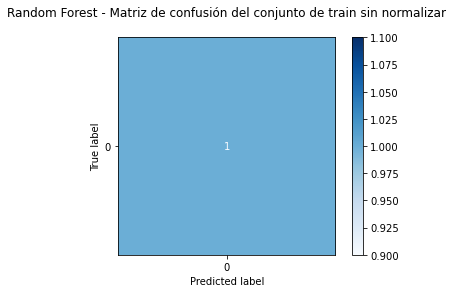

In [247]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

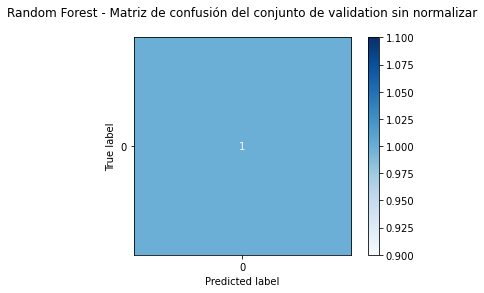

In [248]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## RandomForestClassifier - Grid Search

In [249]:
# Preproceso 1 para SGDRegressor - Default
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = RandomForestClassifier(random_state= 0)

In [250]:
param_grid = {'cla__n_estimators' : [5, 7, 10, 15],
                'cla__criterion':['gini', 'entropy'],
                'cla__min_samples_split': [5, 10, 15, 20, 25],
                'cla__min_samples_leaf':[4, 5, 6, 8],
                'cla__max_features':[0.5, 0.7, 0.8]}

In [251]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [252]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [253]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [254]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='f1', cv=5, verbose=1)

model.fit(X_train, y_train)
rfc_cv = model

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

In [255]:
model.best_params_

{'cla__criterion': 'gini',
 'cla__max_features': 0.5,
 'cla__min_samples_leaf': 4,
 'cla__min_samples_split': 5,
 'cla__n_estimators': 5}

In [256]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [257]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5210

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



In [258]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2233

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

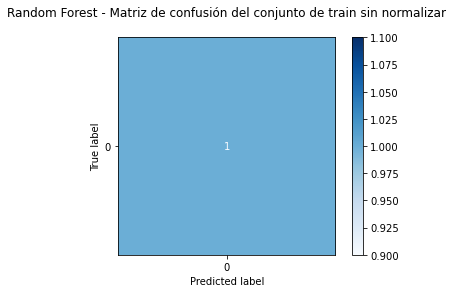

In [259]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

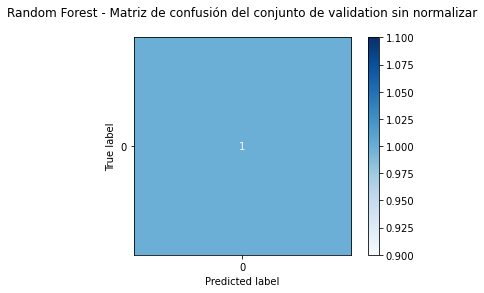

In [260]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## XGBoost - Default

In [261]:
# Preproceso 1 para XGBClassifier - Default
scaler = MaxAbsScaler()
ft_selector = LinearSVR(random_state=0)
model_ = XGBClassifier(random_state= 0)

In [262]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [263]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [264]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [265]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model.fit(X_train, y_train)
xgbc = model

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:30:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [266]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [267]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5210

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



In [268]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2233

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

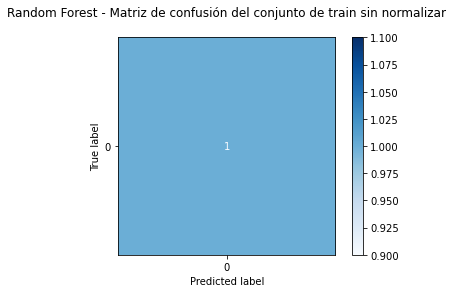

In [269]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

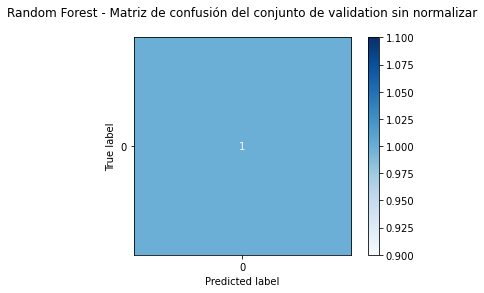

In [270]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## XGBoost - Grid Search

In [271]:
# Preproceso 1 para SGDRegressor - Default
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = XGBClassifier(random_state= 0, use_label_encoder=False)

In [272]:
param_grid = {
    'cla__alpha' : [0.01, 0.42, 0.30],
    'cla__max_depth': [8, 16, 32],
    'cla__n_estimators': [5, 10, 15],
    'cla__booster':['gbtree', 'gblinear', 'dart'],
}

In [273]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [274]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [275]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [276]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='f1', cv=5, verbose=1)

model.fit(X_train, y_train)
xgbc_cv = model

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[21:30:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used w

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluatio

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bin

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bin

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  ave

[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [277]:
model.best_params_

{'cla__alpha': 0.01,
 'cla__booster': 'gbtree',
 'cla__max_depth': 8,
 'cla__n_estimators': 5}

In [278]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [279]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5210

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



In [280]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2233

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

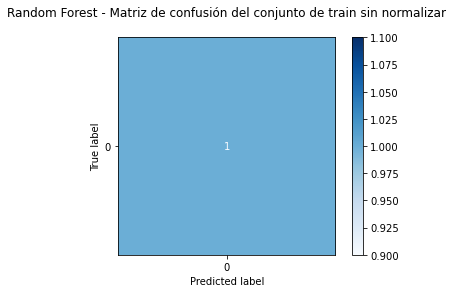

In [281]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

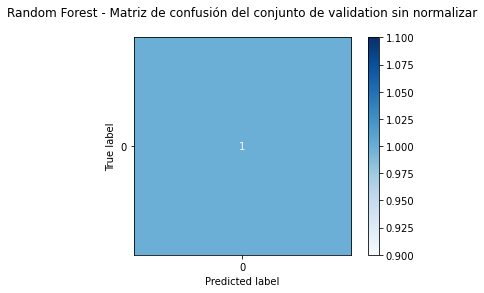

In [282]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## 5. Series Temporales (Optativo)
* Hacer un forecasting usando Exponential Smoothing

En el modelo de Exponential Smoothing, las predicciones son promedios pesados de observaciones pasadas, donde los pesos decaen exponencialmente cuando nos movemos al pasado:
$$
\hat{y}_{t + 1} = l_t \\
l_t = \alpha y_t + (1 - \alpha) l_{t - 1}
$$

Donde:

Asumimos que:
* $l_0$ está dado
* 0 $< \alpha <$ 1

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.


In [283]:
print(statsmodels.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

0.12.2


In [284]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

Para cargar el dataset

In [285]:
df = pd.read_parquet("cupones_ds.parquet")

In [286]:
df.head(5)

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo
0,0001686b52949b5461ffcbc766687e45031,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766.0,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia
1,000220fa96ec5af89817894033f8099c547,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521.0,GLLEN,2020-06-10,SIN DATOS,None,None
2,0002be202de47dfae9cc2304d91161be595,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107.0,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros
3,000e137d0af42e193be1ff670c00d4d1506,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Hombre,Argentina,SANTA FE,SAN LORENZO,2200.0,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia
4,0009d010e4faf69552a814a33832b185877,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019.0,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada


In [287]:
cols = ['producto_naranja_movimiento', 'monto_compra_movimiento', 'fecha_cupon_movimiento']

In [288]:
df[cols]

,producto_naranja_movimiento,monto_compra_movimiento,fecha_cupon_movimiento
0,PL,6.24,2020-08-25
1,PL,17.73,2020-08-25
2,PL,6.18,2020-08-25
3,PL,2.83,2020-08-25
4,PL,2.38,2020-08-25
...,...,...,...
4092072,PL,2.29,2021-02-03
4092073,PL,229.90,2021-01-25
4092074,PL,4.64,2020-09-02
4092075,PL,12.22,2020-11-02


In [289]:
sf = df[cols][df.producto_naranja_movimiento == 'PL']
sf

,producto_naranja_movimiento,monto_compra_movimiento,fecha_cupon_movimiento
0,PL,6.24,2020-08-25
1,PL,17.73,2020-08-25
2,PL,6.18,2020-08-25
3,PL,2.83,2020-08-25
4,PL,2.38,2020-08-25
...,...,...,...
4092072,PL,2.29,2021-02-03
4092073,PL,229.90,2021-01-25
4092074,PL,4.64,2020-09-02
4092075,PL,12.22,2020-11-02


In [290]:
cols = ['fecha_cupon_movimiento', 'monto_compra_movimiento']
sf = sf[cols].groupby(by=['fecha_cupon_movimiento'], dropna=True).sum()

In [291]:
sf.reset_index(inplace=True)
sf

,fecha_cupon_movimiento,monto_compra_movimiento
0,2020-02-16,71760.00
1,2020-04-01,69055.20
2,2020-05-27,146558.07
3,2020-06-25,-22098.63
4,2020-07-01,-39054.00
...,...,...
289,2021-04-30,-235966.89
290,2021-05-02,-1653081.99
291,2021-05-06,3462.42
292,2021-05-10,90.39


In [292]:
print(sf['fecha_cupon_movimiento'].max())
print(sf['fecha_cupon_movimiento'].min())

2021-05-25
2020-02-16


In [293]:
sf.set_index('fecha_cupon_movimiento', inplace=True)
sf

,monto_compra_movimiento
fecha_cupon_movimiento,
2020-02-16,71760.00
2020-04-01,69055.20
2020-05-27,146558.07
2020-06-25,-22098.63
2020-07-01,-39054.00
...,...
2021-04-30,-235966.89
2021-05-02,-1653081.99
2021-05-06,3462.42


En series temporales se usa Series en lugar de Dataframe

In [294]:
ss = sf['monto_compra_movimiento']
ss

fecha_cupon_movimiento
2020-02-16      71760.00
2020-04-01      69055.20
2020-05-27     146558.07
2020-06-25     -22098.63
2020-07-01     -39054.00
                 ...    
2021-04-30    -235966.89
2021-05-02   -1653081.99
2021-05-06       3462.42
2021-05-10         90.39
2021-05-25     320269.71
Name: monto_compra_movimiento, Length: 294, dtype: float64

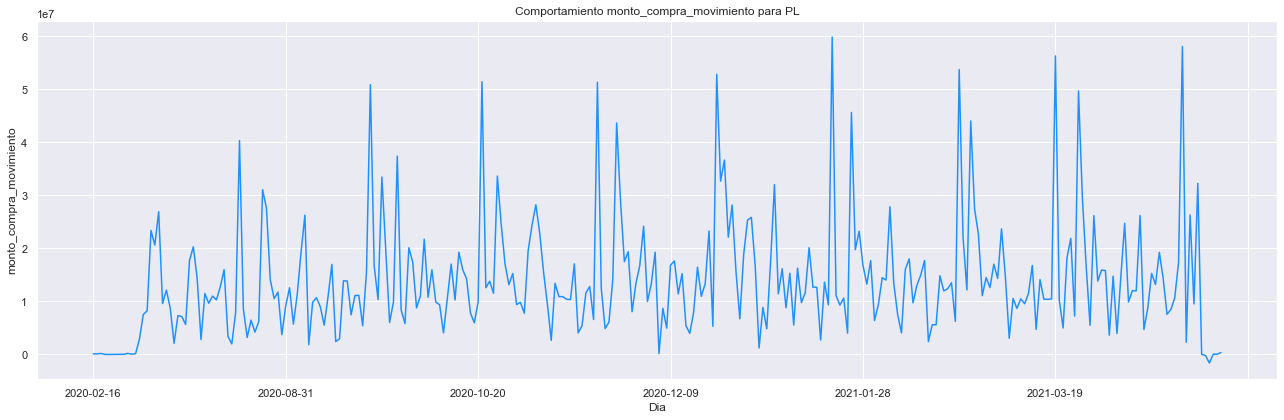

In [295]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
ss.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')
ax.set_title('Comportamiento monto_compra_movimiento para PL')

plt.tight_layout()
plt.show()

In [296]:
y_test = sf.monto_compra_movimiento.loc['2021-03-19':]
y_train = sf[~sf.monto_compra_movimiento.isin(y_test)].monto_compra_movimiento


In [297]:
print(y_test.index.max())
print(y_test.index.min())

2021-05-25
2021-03-19


In [298]:
print(y_train.index.max())
print(y_train.index.min())

2021-03-18
2020-02-16


## Seasonal Random Walk (Seasonal Naïve)

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


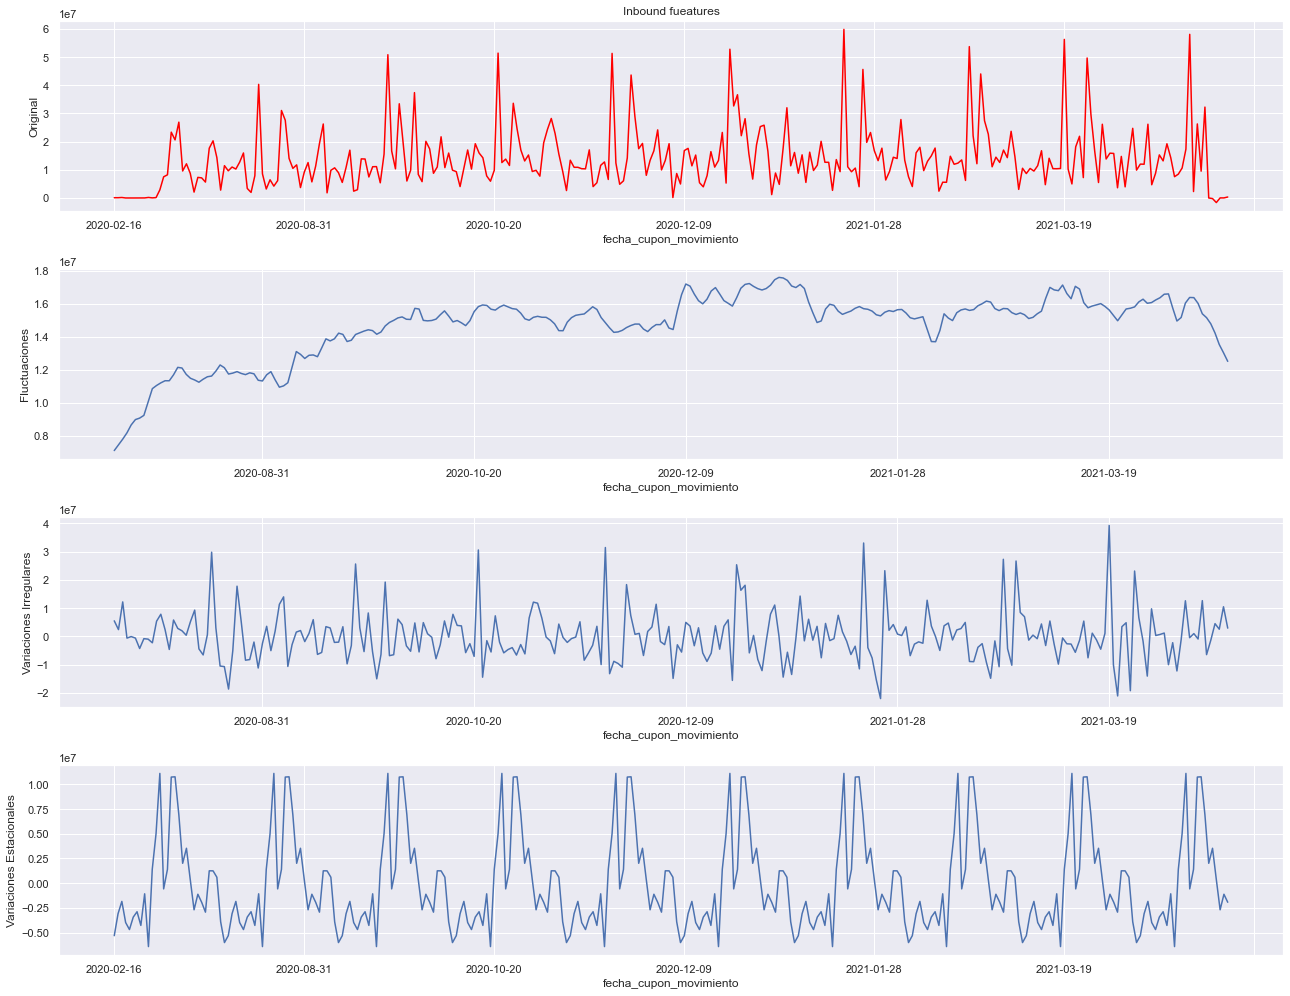

In [299]:
res = sm.tsa.seasonal_decompose(
    sf['monto_compra_movimiento'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
sf.monto_compra_movimiento.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.tight_layout()
plt.show()

## Forecast

In [300]:
model = ARIMA(
    endog=y_train, exog=None, order=(0, 0, 1), seasonal_order=(0, 1, 0, 42)
    ).fit()
    

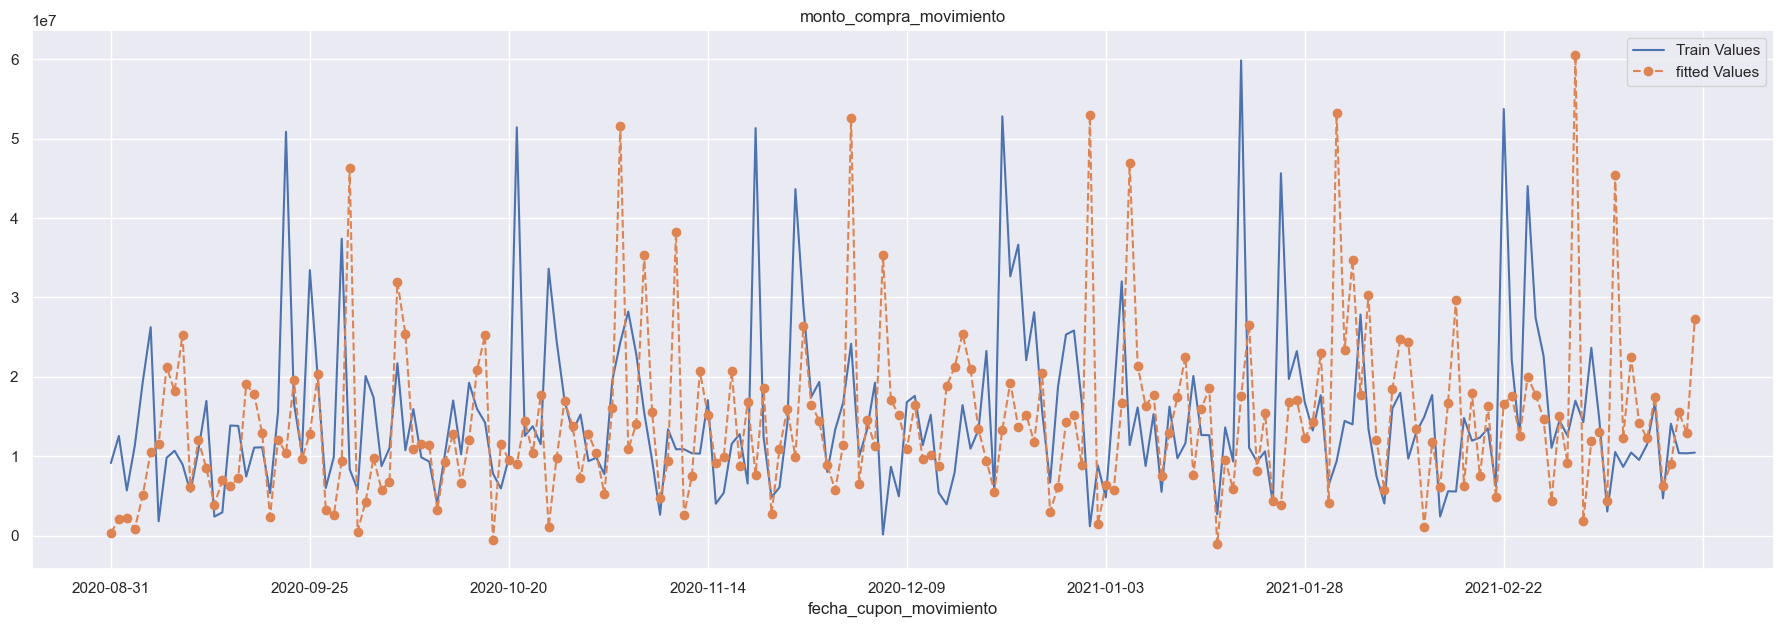

In [301]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('monto_compra_movimiento')
ax.legend()

plt.tight_layout()
plt.show()

In [302]:
# Forecast
# 95% conf se, conf
fc = model.forecast(steps=len(y_test), exog=y_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_test.index

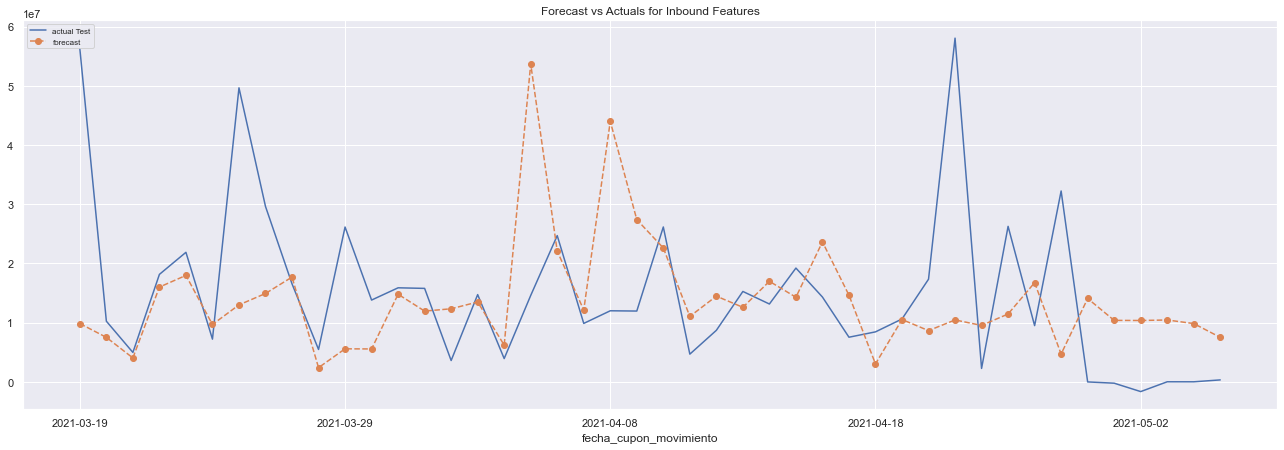

In [303]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [304]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_test, fc_in), 
      (y_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)

,RMSE,SE
0,1.623687e+07,2470284.646
